<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch_%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92%E8%AA%BF%E6%95%B4%E4%B8%AD_Gravcont_attention_residual_network3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch : RESNETを用いたattention residual network

https://github.com/machine-perception-robotics-group/attention_branch_network/blob/master/models/imagenet/resnet.py

https://github.com/bearpaw/pytorch-classification/blob/master/models/imagenet/resnext.py


#自作データ、Early stopping

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline


plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#Google driveのデータをマウント
データの位置
/content/drive/My drive/AI_laboratory_course

In [2]:
'''
フォルダ構成(※class名は4文字にすること)
---dataset.zip-----train-----appl
               |          |--stra
               |
               |---val-------appl
                          |--stra
'''


from google.colab import drive
drive.mount('/content/drive')

#dataset.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/gravcont.zip
!date -R
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Tue, 14 Apr 2020 08:08:08 +0000
Tue, 14 Apr 2020 08:08:23 +0000
data  drive  sample_data  utils


#モジュール群
クリック数を減らすため、まとめてみた


['cont', 'grav']
cont_train:256
grav_train:256
cont_val:65
grav_val:65
training data set_total：512
validating data set_total：130


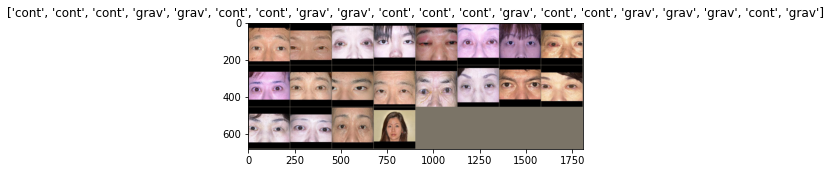

In [3]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path='/content/data/hymenoptera_data/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path='/content/data/hymenoptera_data/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))



#少数の画像を可視化する

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])




#define early stopping class
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


  
  #モデルの訓練
  #★★loss関数にattを加えること！

def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # ★★lossにattを反映させる
                    att_outputs, outputs, _  = model_ft(inputs)
                    _, preds = torch.max(outputs, 1)
                    att_loss = criterion(att_outputs, labels)
                    per_loss = criterion(outputs, labels)
                    loss = att_loss + per_loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
                scheduler.step()
                print('epoch:{}, lr:{}'.format(epoch, scheduler.get_lr()[0]))
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss


#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    #image_tensor.unsqueeze_(0)
    ##print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)


#convnet を再調整する
モデルをロードして最後の完全結合層をリセットします。<br>
※pretrained = False　→事前訓練していない状態になります<br>
※pretrained = True　→事前訓練された状態（強化学習）

In [0]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)



class ResNet_ARN(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet_ARN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], down_size=True)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, down_size=True)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, down_size=True)

        self.att_layer4 = self._make_layer(block, 512, layers[3], stride=1, down_size=False)
        self.bn_att = nn.BatchNorm2d(512 * block.expansion)
        self.att_conv   = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1, padding=0,
                               bias=False)
        self.bn_att2 = nn.BatchNorm2d(num_classes)
        self.att_conv2  = nn.Conv2d(num_classes, num_classes, kernel_size=1, padding=0,
                               bias=False)
        self.att_conv3  = nn.Conv2d(num_classes, 1, kernel_size=3, padding=1,
                               bias=False)
        self.bn_att3 = nn.BatchNorm2d(1)
        self.att_gap = nn.AvgPool2d(14)
        self.sigmoid = nn.Sigmoid()

        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, down_size=True)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, down_size=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        if down_size:
            self.inplanes = planes * block.expansion
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)
        else:
            inplanes = planes * block.expansion
            for i in range(1, blocks):
                layers.append(block(inplanes, planes))

            return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        fe = x

        ax = self.bn_att(self.att_layer4(x))
        ax = self.relu(self.bn_att2(self.att_conv(ax)))
        bs, cs, ys, xs = ax.shape
        self.att = self.sigmoid(self.bn_att3(self.att_conv3(ax)))
        # self.att = self.att.view(bs, 1, ys, xs)
        ax = self.att_conv2(ax)
        ax = self.att_gap(ax)
        ax = ax.view(ax.size(0), -1)

        rx = x * self.att
        rx = rx + x
        per = rx
        rx = self.layer4(rx)
        pre = rx
        rx = self.avgpool(rx)
        rx = rx.view(rx.size(0), -1)
        rx = self.fc(rx)

        return ax, rx, [self.att, fe, per,pre]


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)




def resnetARN18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet_ARN(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


def resnetARN50(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet_ARN(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model



In [0]:
model_origin = resnet50().to(device)
model_ft = resnetARN50().to(device)

#モデルのサマリー（省略可）
#from torchsummary import summary
#summary(model_ft, (3, 224, 224))

#print(model_ft)

# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/resnet50-19c8e357.pth'
model_origin.load_state_dict(torch.load(PATH))

#出力クラスを2に変更する
num_ftrs = model_origin.fc.in_features
model_origin.fc = nn.Linear(num_ftrs, 2)

In [0]:
#Residual attention networkの最終出力を2つにする
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)


In [7]:
#model_ftについてweightを持つ項目のリストを作成
key_list = []
for param in model_origin.state_dict().keys():
    key_list.append(param)
print(key_list)

#model_originの各パラメーターを表示
#for i in key_list:
#    print(model_origin.state_dict()[i])

#model_originのパラメータをmodel_ARNに転移する
param1 = model_origin.state_dict()
param2 = model_ft.state_dict()
for i in range(len(key_list)-2):
    param2[key_list[i]] = param1[key_list[i]]
model_ft.load_state_dict(param2)

#print(model_ARN.state_dict()[key_list[0]])

['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'lay

<All keys matched successfully>

In [0]:
#モデルのサマリー（省略可）
from torchsummary import summary
model_ft.to(device)
summary(model_ft, (3, 224, 224))



#訓練と評価
CPU 上でおよそ 15-25 分かかるはずです。けれども GPU 上なら、1 分もかかりません。

In [0]:
#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=5, num_epochs=25)

Epoch 0/24
----------
epoch:0, lr:0.001
train Loss: 4.0263 Acc: 0.5312
val Loss: 1.7650 Acc: 0.6769
Validation loss decreased (inf --> 1.765039).  Saving model ...

Epoch 1/24
----------
epoch:1, lr:0.001
train Loss: 1.2604 Acc: 0.6895
val Loss: 1.1888 Acc: 0.7077
Validation loss decreased (1.765039 --> 1.188750).  Saving model ...

Epoch 2/24
----------
epoch:2, lr:0.001
train Loss: 1.1037 Acc: 0.7910
val Loss: 1.1226 Acc: 0.7692
Validation loss decreased (1.188750 --> 1.122643).  Saving model ...

Epoch 3/24
----------
epoch:3, lr:0.001
train Loss: 1.0779 Acc: 0.7969
val Loss: 1.2751 Acc: 0.7231
EarlyStopping counter: 1 out of 5

Epoch 4/24
----------
epoch:4, lr:0.001
train Loss: 0.8550 Acc: 0.8555
val Loss: 1.0981 Acc: 0.7846
Validation loss decreased (1.122643 --> 1.098077).  Saving model ...

Epoch 5/24
----------
epoch:5, lr:0.001
train Loss: 0.7622 Acc: 0.8691
val Loss: 0.9239 Acc: 0.8385
Validation loss decreased (1.098077 --> 0.923943).  Saving model ...

Epoch 6/24
---------

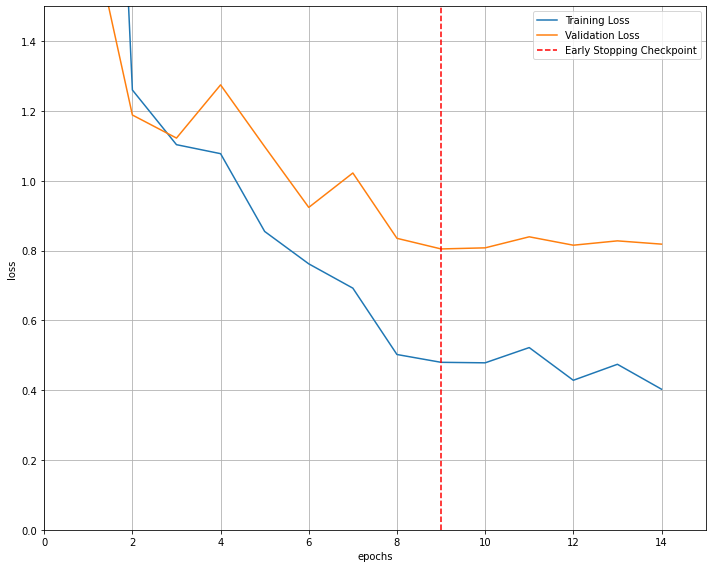

In [10]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#ネットワークの保存と読み込み

In [0]:
PATH = '/content/drive/My Drive/Deep_learning/gravcont_att.pth'
torch.save(model_ft.state_dict(), PATH)

In [210]:
PATH = '/content/drive/My Drive/Deep_learning/gravcont_att.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

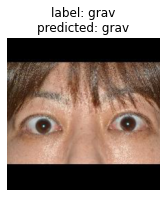

In [12]:
#モデル予測の可視化
def visualize_model(model, num_images=1):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            _, outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2+num_images%2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('label: {}\npredicted: {}'.format(class_names[labels[j]],class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)

#GradCAM

In [0]:
def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.to(device))
    _, N, H, W = feats.size() #[1,2048,7,7]
    out = classifier_fn(feats) #out: [1,1000]
    c_score = out[0, c]   #c_scoreとは？？
    #print(c)
    #print(c_score)

    grads = torch.autograd.grad(outputs=c_score,inputs=feats) #feats(Xに相当)を微分
    w = grads[0][0].mean(-1).mean(-1)           #ここでGlobalAveragePoolingをしている
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0) #ReLUと同じ
    return sal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


"\n_, outputs, attention = model_ft(inputs)\n\nprint(attention[0].size())\nprint(attention[1].size())\nprint(attention[2].size())\nprint(attention[3].size())\n#attention2 = attention.to('cpu').detach().numpy().copy()\n\n#print(attention2)\n"

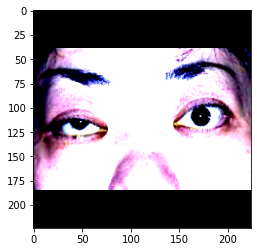

In [54]:
#Dataloaderをbatch size=1で再定義する
data_dir = '/content/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

#dataloaderの中から1つを抜き出す
inputs, labels = iter(dataloaders['val']).next()
inputs, labels = inputs.to('cpu'), labels.to('cpu')
#print(inputs.size())
#print(labels)
#plt.figure(figsize=(5,5))

inputs = np.squeeze(inputs)
print(inputs.size())
inputs = np.transpose(inputs, (1,2,0))
print(inputs.size())

# FigureとAxesを作成
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(inputs)






'''
_, outputs, attention = model_ft(inputs)

print(attention[0].size())
print(attention[1].size())
print(attention[2].size())
print(attention[3].size())
#attention2 = attention.to('cpu').detach().numpy().copy()

#print(attention2)
'''

In [0]:
def show_mask_single(images, mask, Mean=(2, 2, 2), Std=(0.5,0.5,0.5)):
    im_size = images.size(2)

    # save for adding mask
    im_data = images.clone()
    for i in range(0, 3):
        im_data[:,i,:,:] = im_data[:,i,:,:] * Std[i] + Mean[i]    # unnormalize

    images = make_image(torchvision.utils.make_grid(images), Mean, Std)
    plt.subplot(2, 1, 1)
    plt.imshow(images)
    plt.axis('off')

    # for b in range(mask.size(0)):
    #     mask[b] = (mask[b] - mask[b].min())/(mask[b].max() - mask[b].min())
    mask_size = mask.size(2)
    # print('Max %f Min %f' % (mask.max(), mask.min()))
    mask = (upsampling(mask, scale_factor=im_size/mask_size))
    # mask = colorize(upsampling(mask, scale_factor=im_size/mask_size))
    # for c in range(3):
    #     mask[:,c,:,:] = (mask[:,c,:,:] - Mean[c])/Std[c]

    # print(mask.size())
    mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask.expand_as(im_data)))
    # mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask), Mean, Std)
    plt.subplot(2, 1, 2)
    plt.imshow(mask)
    plt.axis('off')




image_path = "/content/data/hymenoptera_data/val/grav/6355.JPG"
im_size = inputs[0].size(2)


In [48]:
for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        print(labels[i])

tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')


#Visualize attention

In [0]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['get_mean_and_std', 'init_params', 'mkdir_p', 'AverageMeter']


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

def mkdir_p(path):
    '''make dir if not exist'''
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
__all__ = ['make_image', 'show_batch', 'show_mask', 'show_mask_single']

# functions to show an image
def make_image(img, mean=(0,0,0), std=(1,1,1)):
    for i in range(0, 3):
        img[i] = img[i] * std[i] + mean[i]    # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def gauss(x,a,b,c):
    return torch.exp(-torch.pow(torch.add(x,-b),2).div(2*c*c)).mul(a)

def colorize(x):
    ''' Converts a one-channel grayscale image to a color heatmap image '''
    if x.dim() == 2:
        torch.unsqueeze(x, 0, out=x)
    if x.dim() == 3:
        cl = torch.zeros([3, x.size(1), x.size(2)])
        cl[0] = gauss(x,.5,.6,.2) + gauss(x,1,.8,.3)
        cl[1] = gauss(x,1,.5,.3)
        cl[2] = gauss(x,1,.2,.3)
        cl[cl.gt(1)] = 1
    elif x.dim() == 4:
        cl = torch.zeros([x.size(0), 3, x.size(2), x.size(3)])
        cl[:,0,:,:] = gauss(x,.5,.6,.2) + gauss(x,1,.8,.3)
        cl[:,1,:,:] = gauss(x,1,.5,.3)
        cl[:,2,:,:] = gauss(x,1,.2,.3)
    return cl

def show_batch(images, Mean=(2, 2, 2), Std=(0.5,0.5,0.5)):
    images = make_image(torchvision.utils.make_grid(images), Mean, Std)
    plt.imshow(images)
    plt.show()


def show_mask_single(images, mask, Mean=(2, 2, 2), Std=(0.5,0.5,0.5)):
    im_size = images.size(2)

    # save for adding mask
    im_data = images.clone()
    for i in range(0, 3):
        im_data[:,i,:,:] = im_data[:,i,:,:] * Std[i] + Mean[i]    # unnormalize

    images = make_image(torchvision.utils.make_grid(images), Mean, Std)
    plt.subplot(2, 1, 1)
    plt.imshow(images)
    plt.axis('off')

    # for b in range(mask.size(0)):
    #     mask[b] = (mask[b] - mask[b].min())/(mask[b].max() - mask[b].min())
    mask_size = mask.size(2)
    # print('Max %f Min %f' % (mask.max(), mask.min()))
    mask = (upsampling(mask, scale_factor=im_size/mask_size))
    # mask = colorize(upsampling(mask, scale_factor=im_size/mask_size))
    # for c in range(3):
    #     mask[:,c,:,:] = (mask[:,c,:,:] - Mean[c])/Std[c]

    # print(mask.size())
    mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask.expand_as(im_data)))
    # mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask), Mean, Std)
    plt.subplot(2, 1, 2)
    plt.imshow(mask)
    plt.axis('off')

def show_mask(images, masklist, Mean=(2, 2, 2), Std=(0.5,0.5,0.5)):
    im_size = images.size(2)

    # save for adding mask
    im_data = images.clone()
    for i in range(0, 3):
        im_data[:,i,:,:] = im_data[:,i,:,:] * Std[i] + Mean[i]    # unnormalize

    images = make_image(torchvision.utils.make_grid(images), Mean, Std)
    plt.subplot(1+len(masklist), 1, 1)
    plt.imshow(images)
    plt.axis('off')

    for i in range(len(masklist)):
        mask = masklist[i].data.cpu()
        # for b in range(mask.size(0)):
        #     mask[b] = (mask[b] - mask[b].min())/(mask[b].max() - mask[b].min())
        mask_size = mask.size(2)
        # print('Max %f Min %f' % (mask.max(), mask.min()))
        mask = (upsampling(mask, scale_factor=im_size/mask_size))
        # mask = colorize(upsampling(mask, scale_factor=im_size/mask_size))
        # for c in range(3):
        #     mask[:,c,:,:] = (mask[:,c,:,:] - Mean[c])/Std[c]

        # print(mask.size())
        mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask.expand_as(im_data)))
        # mask = make_image(torchvision.utils.make_grid(0.3*im_data+0.7*mask), Mean, Std)
        plt.subplot(1+len(masklist), 1, i+2)
        plt.imshow(mask)
        plt.axis('off')


img_path = '/content/drive/My Drive/Deep_learning/applstra/val/appl/Red_Apple.jpg'



